In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [17]:
data = pd.read_csv("C:/Users/luizf/Desktop/MINDS/Datasets/energydata_complete.csv")
data.pop('date')
data.pop('rv1')
data.pop('rv2')
#data.pop('T9')
#data.pop('T6')
#data.pop('Windspeed')
X=data.copy()
X.drop(data.tail(1).index,inplace=True)
X
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
1,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
2,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
3,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
4,50.0,40.0,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,45.730000,...,18.1000,48.590000,17.000000,45.2900,6.016667,734.0,92.000000,5.333333,43.833333,4.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19729,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19730,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19731,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19732,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=32)

y_train, y_test = train_test_split(y, test_size=0.25, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
y_train = scaler.fit_transform(y_train.values)
y_val = scaler.fit_transform(y_val.values)

In [19]:
#lr decay

#batch norm
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim,nonlinearity='relu', batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [20]:
def train_rnn(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
        #y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
        #y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = RNNModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [21]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [22]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    scaler = StandardScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_rnn(X_train, layer_dim=1, dropout_prob=0, epochs=300, batch_size=64, learning_rate=0.001, step_wdecay=50, gamma_wdecay=0.5)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_25584/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.n

In [23]:
result

,window,rmse,mape,mae,r2,variable,smape,nrmse
0,0,90.648653,59.852595,60.536642,0.402275,Appliances,23.179264,0.188851
1,0,5.482111,inf,4.395911,0.403813,lights,72.349379,0.182737
2,0,0.387215,1.436965,0.316912,0.727445,T1,0.719115,0.154886
3,0,1.365928,2.171352,0.845128,0.465812,RH_1,1.075364,0.099268
4,0,0.468979,1.750426,0.369685,0.633001,T2,0.871906,0.139994
...,...,...,...,...,...,...,...,...
775,19082,0.258000,0.024820,0.187630,0.297501,Press_mm_hg,0.012412,0.184286
776,19082,3.324140,4.089530,2.642354,0.948869,RH_out,2.082602,0.073870
777,19082,0.734814,28.405746,0.599298,0.229362,Windspeed,14.554860,0.244938
778,19082,11.536482,27.356013,8.941867,0.429360,Visibility,11.202284,0.262193


In [24]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_25584/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_25584/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


,variable,rmse,mae,mape,r2,smape,nrmse,rmse_std,mae_std,mape_std,r2_std,smape_std,nrmse_std
0,Appliances,75.018830,47.678530,55.084148,2.584307e-01,22.073892,0.135804,34.274277,24.761111,24.275961,1.496919e-01,8.303245,0.032246
1,lights,5.911851,4.308437,inf,1.540046e-01,85.147337,inf,2.512238,2.110918,NaN,2.672989e-01,12.063740,NaN
2,T1,0.268541,0.215006,1.008584,7.833755e-01,0.503731,0.134230,0.145534,0.111268,0.566707,1.268369e-01,0.280511,0.038814
3,RH_1,0.969444,0.710772,1.774115,6.136861e-01,0.888249,0.114805,0.421205,0.356796,0.985415,2.354177e-01,0.494819,0.030641
4,T2,0.499525,0.402389,1.955252,7.696968e-01,0.977618,0.137234,0.263121,0.208665,0.958325,1.549592e-01,0.477169,0.045787
5,RH_2,0.952256,0.738389,1.887108,6.813338e-01,0.939301,0.134121,0.447107,0.354031,1.032620,2.657997e-01,0.504402,0.057790
6,T3,0.317077,0.247519,1.096028,4.545026e-01,0.547798,0.173141,0.176538,0.140994,0.596603,3.453399e-01,0.297559,0.068270
7,RH_3,0.661694,0.517944,1.325046,6.015167e-01,0.662692,0.142142,0.362589,0.294306,0.754354,1.972442e-01,0.378370,0.034647
8,T4,0.405724,0.319848,1.580725,5.163748e-01,0.789689,0.176500,0.288392,0.229277,1.175252,2.528782e-01,0.583932,0.042207
9,RH_4,0.693673,0.562953,1.437955,6.275496e-01,0.718587,0.143670,0.299698,0.255788,0.651957,2.146994e-01,0.325935,0.041998


In [25]:
pd.DataFrame(final_measures).to_csv('rnn_appliances_result.csv')

In [53]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.03597312479839225


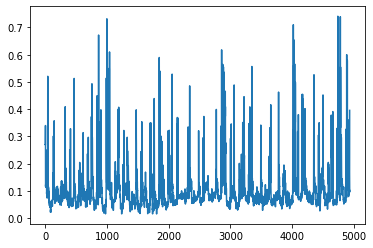

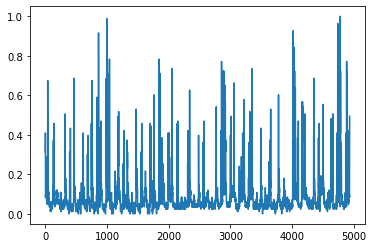

In [54]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [110]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        self.relu = nn.LeakyReLU(inplace=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.relu(out)
        print (out)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [111]:
torch.manual_seed(1)
alpha = 5
h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
model = LSTMModel(X_train.shape[1],h, 1,X_train.shape[1],0.2)
if torch.cuda.is_available():
    model = model.cuda()
else:
    model = model.cuda()
criterion = torch.nn.MSELoss()
print (model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000
steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
epochs = 30

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]
    steplr.step()

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader:  
        if torch.cuda.is_available():
            dv =dv.cuda()  
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

C:\Users\luizf\miniconda3\envs\test\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<generator object Module.parameters at 0x000001302504B2E0>
tensor([[[-1.7639e-04, -5.5214e-04,  7.5940e-03,  ..., -2.5195e-04,
           4.0040e-02, -7.9908e-04]],

        [[-1.6867e-04, -5.6029e-04,  5.7086e-03,  ..., -2.4645e-04,
           3.8267e-02, -7.9896e-04]],

        [[-1.5744e-04, -5.6746e-04,  4.5386e-03,  ..., -2.4989e-04,
           3.7307e-02, -7.9199e-04]],

        ...,

        [[-1.1652e-04, -6.7746e-04, -5.1109e-05,  ..., -3.1282e-04,
           4.1329e-02, -9.1663e-04]],

        [[-9.8464e-05, -6.7725e-04, -4.1514e-05,  ..., -3.3056e-04,
           4.1014e-02, -9.2001e-04]],

        [[-7.7257e-05, -6.2851e-04, -5.6540e-05,  ..., -4.1955e-04,
           3.6711e-02, -8.7867e-04]]], device='cuda:0',
       grad_fn=<LeakyReluBackward1>)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [32, 1, 55]], which is output 0 of CudnnRnnBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [99]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.02753593302994971


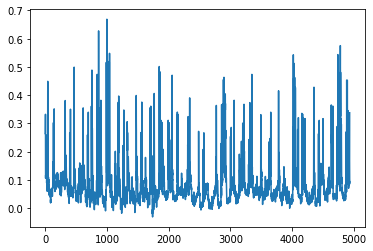

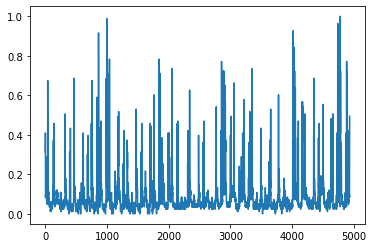

In [58]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [59]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [22]:
torch.manual_seed(1)
model = GRUModel(X_train.shape[1],150, 2,X_train.shape[1],0)
if torch.cuda.is_available():
    model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000

epochs = 20

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader: 
        if torch.cuda.is_available():
            dv =dv.cuda()   
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

Epoch 1 		 Training Loss: 0.0341407508532597 		 Validation Loss: 0.05373881666788033
Epoch 2 		 Training Loss: 0.019735000150628047 		 Validation Loss: 0.03987534157931805
Epoch 3 		 Training Loss: 0.01609961776214127 		 Validation Loss: 0.036602970425571715
Epoch 4 		 Training Loss: 0.013242797208666272 		 Validation Loss: 0.031005856820515224
Epoch 5 		 Training Loss: 0.010421584776323762 		 Validation Loss: 0.02784332148730755
Epoch 6 		 Training Loss: 0.008603904424660701 		 Validation Loss: 0.0266323769731181
Epoch 7 		 Training Loss: 0.007447281974098328 		 Validation Loss: 0.026176552660763262
Epoch 8 		 Training Loss: 0.006611950628147437 		 Validation Loss: 0.024893538121666225
Epoch 9 		 Training Loss: 0.005915701909931519 		 Validation Loss: 0.023702464625239374
Epoch 10 		 Training Loss: 0.00532518656744721 		 Validation Loss: 0.02227746554251228
Epoch 11 		 Training Loss: 0.004822278233968327 		 Validation Loss: 0.02055887851331915
Epoch 12 		 Training Loss: 0.004329035039

In [23]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.06911269190394034


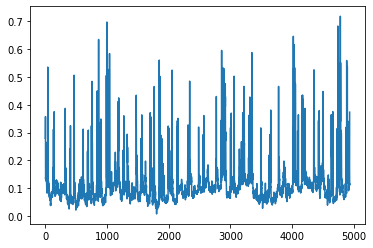

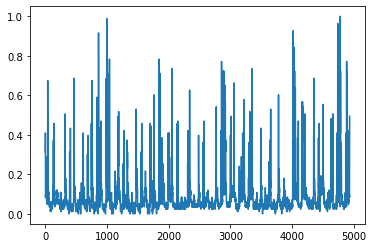

In [20]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [24]:
print (model)

GRUModel(
  (gru): GRU(22, 20, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
